<a href="https://colab.research.google.com/github/phanee16/something/blob/main/RoadNet_Efficient_Road_Segmentation_using_UNet_and_EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-q_x9mvnv
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-q_x9mvnv
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

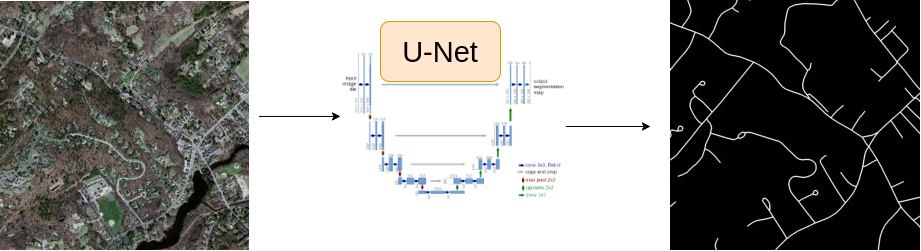

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:

csv_file = '/content/Road_seg_dataset/train.csv'
data_dir = '/content/Road_seg_dataset/'

# Device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Device = 'cuda'
Batch_size = 8
Image_size = 512
learning_rate = 0.003
epochs = 25
encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png
...,...,...
194,images/18178735_15.png,masks/18178735_15.png
195,images/24178480_15.png,masks/24178480_15.png
196,images/24629305_15.png,masks/24629305_15.png
197,images/23728495_15.png,masks/23728495_15.png


In [ ]:
idx = 2
row = df.iloc[idx]

image_path = data_dir + row.images
mask_path = data_dir + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255

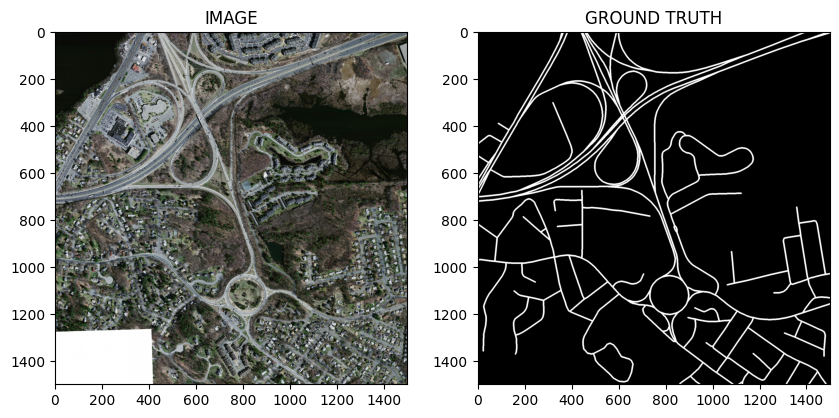

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
    A.Resize(Image_size,Image_size),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5)
    ])


def get_valid_augs():
  return A.Compose([
    A.Resize(Image_size,Image_size)
    ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = df.iloc[idx]

        image_path = data_dir+row.images
        mask_path = data_dir+row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask,axis = -1)


        if self.augmentations:
            data = self.augmentations(image=image,mask = mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask,(2,0,1)).astype(np.float32)

        image = torch.Tensor(image)/255.0
        mask = torch.round(torch.Tensor(mask)/255.0)

        return image,mask

In [ ]:
train_set = SegmentationDataset(train_df,get_train_augs())
valid_set = SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print("The total examples in the train set: ",len(train_set))
print("The total examples in the train set: ",len(valid_set))

The total examples in the train set:  159
The total examples in the train set:  40


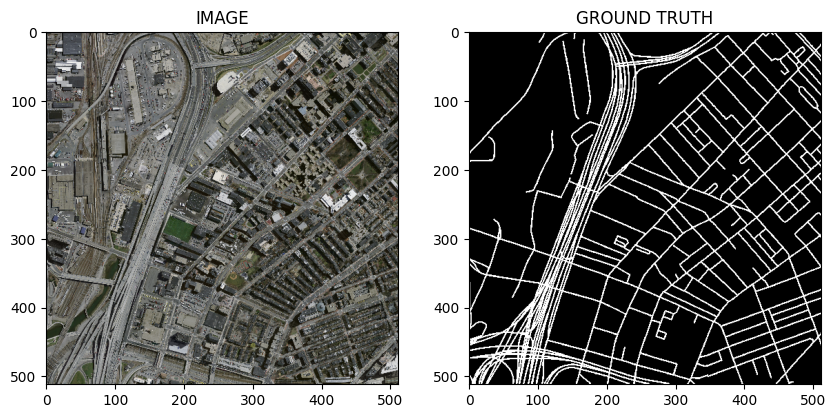

In [ ]:
idx = 10

image,mask = train_set[idx]

helper.show_image(image,mask)

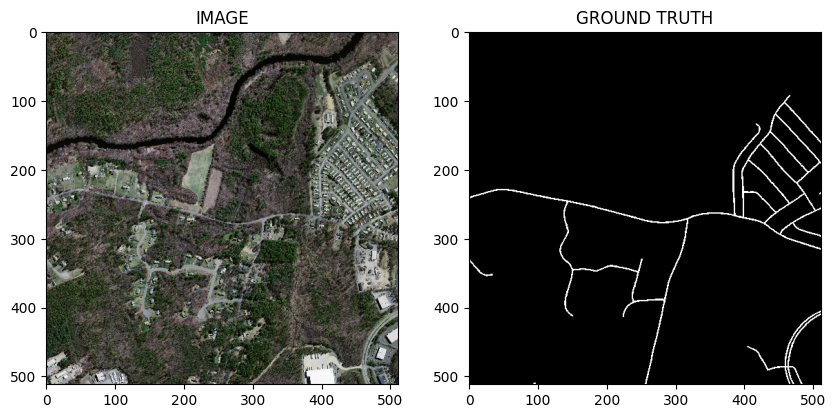

In [ ]:
idx = 56

image,mask = train_set[idx]

helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader


In [ ]:
trainloader = torch.utils.data.DataLoader(train_set,batch_size= Batch_size, shuffle= True)
validloader = torch.utils.data.DataLoader(valid_set,batch_size= Batch_size)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 20
Total no. batches in validloader : 5


In [ ]:
for images,masks in trainloader:
  break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch masks : {}".format(masks.shape))

Shape of one batch images : torch.Size([8, 3, 512, 512])
Shape of one batch masks : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn


In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3,
        classes = 1,
        activation= None
    )

  def forward(self,images,masks = None):

    logits = self.backbone(images)

    if masks!=None:
      return logits, DiceLoss(mode = 'binary')(logits,masks) + nn.BCEWithLogitsLoss()(logits,masks)
    return logits

In [ ]:
model = SegmentationModel()
model.to(Device)

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(model,DataLoader,optimizer):
  total_loss = 0.0
  model.train()

  for images,masks in tqdm(DataLoader):

    images = images.to(Device)
    masks = masks.to(Device)

    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(DataLoader)

In [ ]:
def eval_fn(model,DataLoader):
  total_loss = 0.0
  model.train()

  with torch.no_grad():

    for images,masks in tqdm(DataLoader):

      images = images.to(Device)
      masks = masks.to(Device)
      logits,loss = model(images,masks)
      total_loss += loss.item()

  return total_loss/len(DataLoader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:

best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_fn(model,trainloader,optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1} train loss : {train_loss} , valid loss : {valid_loss}')

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED-MODEL
Epoch : 1 train loss : 1.12524571120739 , valid loss : 0.8536357760429383


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED-MODEL
Epoch : 2 train loss : 0.7965546697378159 , valid loss : 0.7500873923301696


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 3 train loss : 0.7242094129323959 , valid loss : 0.7455995440483093


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 4 train loss : 0.697692483663559 , valid loss : 0.7353038549423218


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


SAVED-MODEL
Epoch : 5 train loss : 0.680370706319809 , valid loss : 0.6489218831062317


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 6 train loss : 0.6708816379308701 , valid loss : 0.6397979855537415


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 7 train loss : 0.69407739341259 , valid loss : 0.6919526338577271


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 8 train loss : 0.6559778839349747 , valid loss : 0.6700013399124145


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 9 train loss : 0.6391085118055344 , valid loss : 0.6284006714820862


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 10 train loss : 0.6324355274438858 , valid loss : 0.681973934173584


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 11 train loss : 0.6242475122213363 , valid loss : 0.633244264125824


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


SAVED-MODEL
Epoch : 12 train loss : 0.6223735064268112 , valid loss : 0.6049030780792236


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 13 train loss : 0.6231498658657074 , valid loss : 0.6242172956466675


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


SAVED-MODEL
Epoch : 14 train loss : 0.6178885191679001 , valid loss : 0.593416166305542


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


SAVED-MODEL
Epoch : 15 train loss : 0.6151471734046936 , valid loss : 0.5861765086650849


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch : 16 train loss : 0.6079175680875778 , valid loss : 0.5983738601207733


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Epoch : 17 train loss : 0.6008815348148346 , valid loss : 0.6197893381118774


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


SAVED-MODEL
Epoch : 18 train loss : 0.5930831372737885 , valid loss : 0.5590405225753784


100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Epoch : 19 train loss : 0.5931558787822724 , valid loss : 0.6648129105567933


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch : 20 train loss : 0.586246882379055 , valid loss : 0.584170913696289


100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Epoch : 21 train loss : 0.601693308353424 , valid loss : 0.5788603782653808


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch : 22 train loss : 0.5854617327451705 , valid loss : 0.6198543906211853


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


Epoch : 23 train loss : 0.5787851765751839 , valid loss : 0.5595600962638855


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


Epoch : 24 train loss : 0.5908700466156006 , valid loss : 0.5845234751701355


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

Epoch : 25 train loss : 0.5847491472959518 , valid loss : 0.5686211228370667


# Task 9 : Inference

In [ ]:
idx = 16
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = valid_set[idx]

logits_mask = model(image.to(Device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

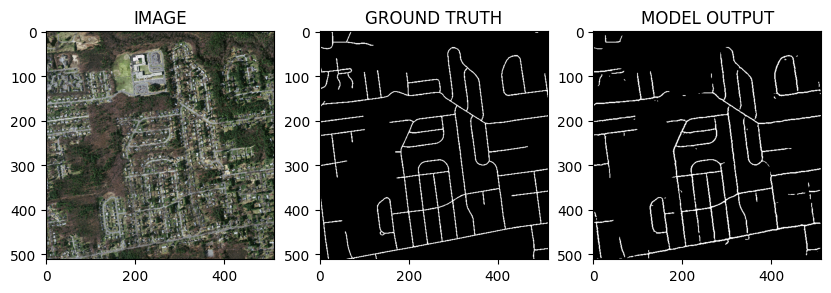

In [ ]:
helper.show_image(image,mask, pred_mask.detach().cpu().squeeze(0))